In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요패키지 로드
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter

from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from arch import arch_model

In [ ]:
# 데이터 전처리
train_df = pd.read_csv('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/train.csv')
train_df = train_df.groupby('Date')[['Weekly_Sales']].mean()
train_df.insert(0,'Date',train_df.index)
train_df.index = range(0,len(train_df))
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [ ]:
# 훈련 평가 데이터셋 구분
ratio = int(len(train_df) *0.8)
test_df = train_df.iloc[ratio:,:]
test_df = test_df.reset_index(drop = True)
train_df = train_df.iloc[:ratio,:]

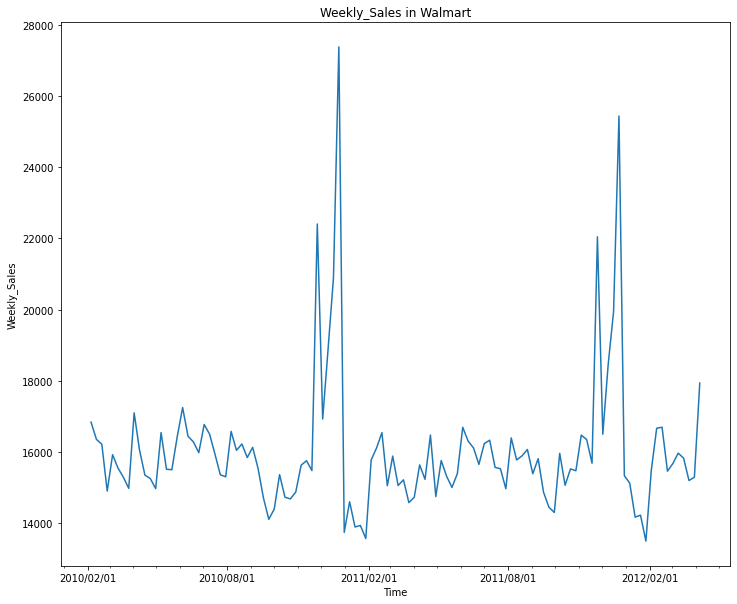

In [ ]:
# 시계열 그래프
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.plot(train_df['Date'],train_df['Weekly_Sales'])
ax.xaxis.set_major_locator(MonthLocator(interval=6)) 
ax.xaxis.set_major_formatter(DateFormatter('%Y/%m/%d')) 
ax.xaxis.set_minor_locator(MonthLocator(interval=1))  
plt.ylabel('Weekly_Sales')
plt.xlabel('Time')
plt.title('Weekly_Sales in Walmart')
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/Time-series.png',dpi=300)
plt.show()

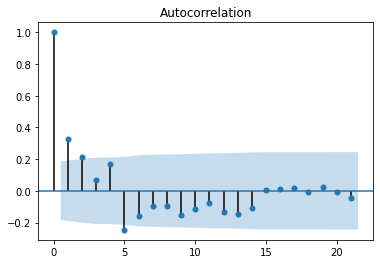

In [ ]:
# ACF
sm.graphics.tsa.plot_acf(np.array(train_df['Weekly_Sales']))
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/ACF.png',dpi=300)

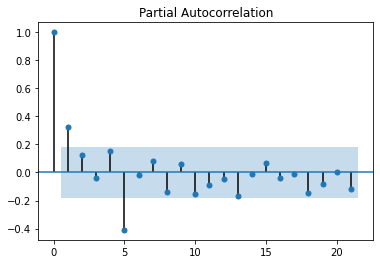

In [ ]:
#PACF
sm.graphics.tsa.plot_pacf(np.array(train_df['Weekly_Sales']))
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/PACF.png',dpi=300)

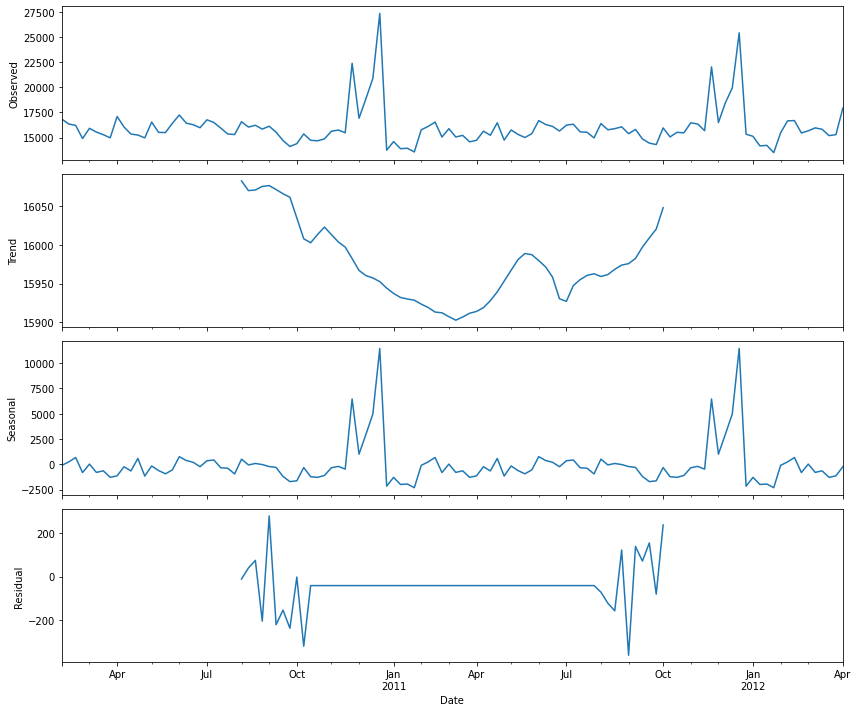

In [ ]:
# 시계열 분해
seasonal_DF = train_df.set_index(train_df['Date'])
seasonal_result = seasonal_decompose(seasonal_DF['Weekly_Sales'],model='additive')
plt.rcParams['figure.figsize'] = [12, 10]
seasonal_result.plot()
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/Seasonal.png',dpi=300)
plt.show()

In [ ]:
# ADF-TEST
adfuller(train_df['Weekly_Sales'], autolag="AIC")

(-5.3113391203880544,
 5.18715388095781e-06,
 4,
 109,
 {'1%': -3.49181775886872,
  '10%': -2.5811201893779985,
  '5%': -2.8884437992971588},
 1791.074877163992)

In [ ]:
#AR model
AR_model = ARIMA(train_df['Weekly_Sales'], order=(2,0,0))
AR_model_fit = AR_model.fit(trend='nc',full_output=True, disp=1)
print(AR_model_fit.summary()) 

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                     ARMA(2, 0)   Log Likelihood               -1034.992
Method:                       css-mle   S.D. of innovations           2081.529
Date:                Sun, 19 Jun 2022   AIC                           2075.985
Time:                        21:56:51   BIC                           2084.193
Sample:                             0   HQIC                          2079.316
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.Weekly_Sales     0.5835      0.085      6.830      0.000       0.416       0.751
ar.L2.Weekly_Sales     0.4110      0.086      4.798      0.000       0.243       0.579
                    

In [ ]:
# AR Model 예측
y_pred_AR = AR_model_fit.predict(1,len(test_df))

In [ ]:
# AR Model 성능 지표
mae_AR = metrics.mean_absolute_error(test_df['Weekly_Sales'],y_pred_AR)
rmse_AR = metrics.mean_squared_error(test_df['Weekly_Sales'],y_pred_AR)
Error_AR = pd.DataFrame([[mae_AR,rmse_AR]],columns = ['MAE','RMSE'])

In [ ]:
#MA Model
MA_model = ARIMA(train_df['Weekly_Sales'], order=(0,0,2))
MA_model_fit = MA_model.fit(trend='nc',full_output=True, disp=1)
print(MA_model_fit.summary()) 

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                     ARMA(0, 2)   Log Likelihood               -1144.589
Method:                       css-mle   S.D. of innovations           5336.422
Date:                Sun, 19 Jun 2022   AIC                           2295.178
Time:                        20:02:01   BIC                           2303.387
Sample:                             0   HQIC                          2298.510
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ma.L1.Weekly_Sales     1.4744      0.043     34.282      0.000       1.390       1.559
ma.L2.Weekly_Sales     0.9999      0.043     23.289      0.000       0.916       1.084
                    

In [ ]:
#MA Model 예측
y_pred_MA = MA_model_fit.predict(1,len(test_df))

In [ ]:
#MA Model 성능 지표
mae_MA = metrics.mean_absolute_error(test_df['Weekly_Sales'],y_pred_MA)
rmse_MA = metrics.mean_squared_error(test_df['Weekly_Sales'],y_pred_MA)
Error_MA = pd.DataFrame([[mae_MA,rmse_MA]],columns = ['MAE','RMSE'])

In [ ]:
#ARMA model
from statsmodels.tsa.arima_model import ARIMA
ARMA_model = ARIMA(train_df['Weekly_Sales'], order=(2,0,2))
ARMA_model_fit = ARMA_model.fit(trend='nc',full_output=True, disp=1)
print(ARMA_model_fit.summary()) 

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                     ARMA(2, 2)   Log Likelihood               -1029.622
Method:                       css-mle   S.D. of innovations           1982.653
Date:                Sun, 19 Jun 2022   AIC                           2069.245
Time:                        20:02:04   BIC                           2082.926
Sample:                             0   HQIC                          2074.797
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.Weekly_Sales     0.1137      0.120      0.950      0.344      -0.121       0.348
ar.L2.Weekly_Sales     0.8838      0.120      7.386      0.000       0.649       1.118
ma.L1.Weekly_Sales  

In [ ]:
# ARMA Model 예측
y_pred_ARMA = ARMA_model_fit.predict(1,len(test_df))

In [ ]:
# ARMA Model 성능지표
mae_ARMA = metrics.mean_absolute_error(test_df['Weekly_Sales'],y_pred_ARMA)
rmse_ARMA = metrics.mean_squared_error(test_df['Weekly_Sales'],y_pred_ARMA)
Error_ARMA = pd.DataFrame([[mae_ARMA,rmse_ARMA]],columns = ['MAE','RMSE'])

In [ ]:
# ARMA-GARCH
arima_residuals = arima_model_fitted.resid
garch = arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1024.2374286281909
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1019.7234993996321
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1017.7931741733502
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1017.1973206494665
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1017.0508922536994
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1017.044837844321
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1017.0391704738059
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1017.039041740441
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1017.0390366964277
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1017.0390366964924
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.345e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1017.04
Distribution:                  Normal   AIC:                           2042.08
Method:            Maximum Likelihood   BIC:                           2053.02
                                        No. Observations:                  114
Date:                Sun, Jun 19 2022   Df Residuals:                      113
Time:                        22:22:04   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           193.2391    407.069      0.475      0.635 [-6.046e+02,9.911e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.3448e+05  6.439e+05      0.985      0.324 [-6.275e+05,1.896e+06]
alpha[1]       0.4617      1.883      0.245      0.806      [ -3.228,  4.152]
beta[1]        0.4324      1.060      0.408      0.683      [ -1.645,  2.510]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
#ARMA 잔차를 GARCH를 통해 예측
predicted_mu = arima_model_fitted.predict(1,len(test_df))
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
y_pred_ARMA_GARCH = predicted_mu + predicted_et


In [ ]:
# ARMA-GARCH 성능지표
mae_ARMA_GARCH = metrics.mean_absolute_error(test_df['Weekly_Sales'],y_pred_ARMA_GARCH)
rmse_ARMA_GARCH = metrics.mean_squared_error(test_df['Weekly_Sales'],y_pred_ARMA_GARCH)
Error_ARMA_GARCH = pd.DataFrame([[mae_ARMA_GARCH,rmse_ARMA_GARCH]],columns = ['MAE','RMSE'])

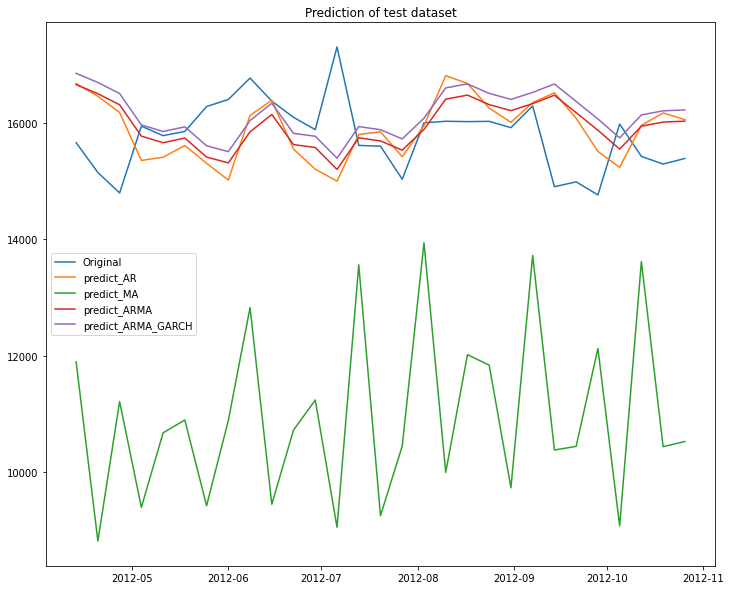

In [ ]:
#Test셋과 4개 모형 예측 비교
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.plot(test_df['Date'],test_df['Weekly_Sales'], label = 'Original')
ax.plot(test_df['Date'],y_pred_AR, label = 'predict_AR')
ax.plot(test_df['Date'],y_pred_MA, label = 'predict_MA')
ax.plot(test_df['Date'],y_pred_ARMA, label = 'predict_ARMA')
ax.plot(test_df['Date'],y_pred_ARMA_GARCH, label = 'predict_ARMA_GARCH')
plt.title('Prediction of test dataset')
ax.legend()
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/Comparison.png',dpi=300)
plt.show()

In [ ]:
# 성능지표 데이터 프레임 통일
Error_AR.index = ["AR"]
Error_MA.index = ["MA"]
Error_ARMA.index = ["ARMA"]
Error_ARMA_GARCH.index = ["ARMA_GARCH"]

Error_data = pd.DataFrame(columns=['MAE',"RMSE"])
Error_data = Error_data.append([Error_AR,Error_MA,Error_ARMA,Error_ARMA_GARCH])

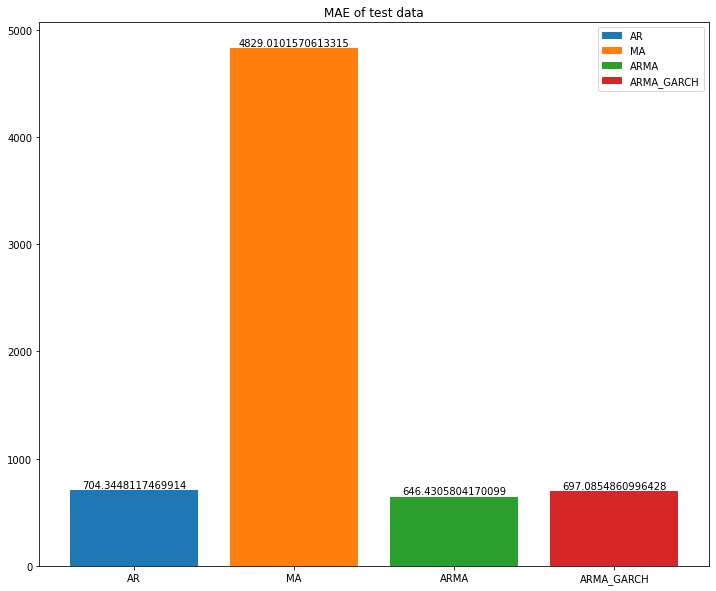

In [ ]:
# 모형 MAE 비교
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.bar(Error_data.index[0],Error_data['MAE'][0],label=Error_data.index[0])
ax.bar(Error_data.index[1],Error_data['MAE'][1],label=Error_data.index[1])
ax.bar(Error_data.index[2],Error_data['MAE'][2],label=Error_data.index[2])
ax.bar(Error_data.index[3],Error_data['MAE'][3],label=Error_data.index[3])
for i, j in enumerate(Error_data.index):
    plt.text(Error_data.index[i], Error_data['MAE'][i], Error_data['MAE'][i],                 
             fontsize = 10, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom') 
plt.title('MAE of test data')
ax.legend(loc='best')
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/MAE.png',dpi=300)
plt.show()

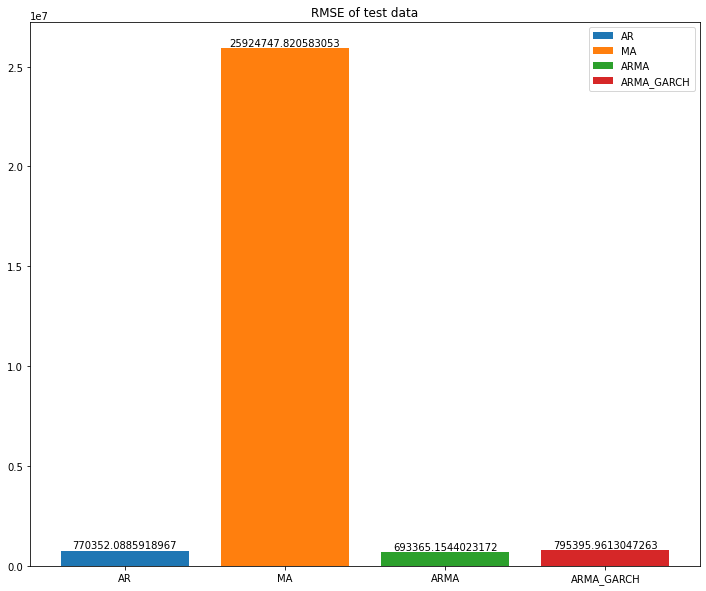

In [ ]:
# 모형 RMSE 비교
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()
ax.bar(Error_data.index[0],Error_data['RMSE'][0],label=Error_data.index[0])
ax.bar(Error_data.index[1],Error_data['RMSE'][1],label=Error_data.index[1])
ax.bar(Error_data.index[2],Error_data['RMSE'][2],label=Error_data.index[2])
ax.bar(Error_data.index[3],Error_data['RMSE'][3],label=Error_data.index[3])
for i, j in enumerate(Error_data.index):
    plt.text(Error_data.index[i], Error_data['RMSE'][i], Error_data['RMSE'][i],                 
             fontsize = 10, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom') 
plt.title('RMSE of test data')
ax.legend(loc='best')
plt.savefig('/content/drive/MyDrive/대학원시계열_최종레포트/Time_Series/Final_Report/RMSE.png',dpi=300)
plt.show()